# Clustering schools

This is my first public kernel (yay)!  Here, I will do a very simple thing: group schools by different sets of characteristics (for example, ethnicity, framework measures, achievement performance, ...)

My hope is that by providing different groupings, PASSNYC may get a good idea of what works for one group or another. For example, let's consider 2 schools *X* and *Y*, that belong to the same group. PASSNYC may reach for school *X*, and, discover new things that are useful in *X*. Now, based on the fact that these two schools are similar, what works for *X* may also work for *Y* too.

By providing different groupings, I may stumble upon one that works best. Also, it provides a nice framework for visualizing information on a map.

## Preparing the data

In [338]:
import re

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)


df = pd.read_csv('../data/raw/2016 School Explorer.csv')

# set index
df = df.set_index('Location Code')
df.index.name = 'DBN'

# remove unused columns
columns = [
    'Adjusted Grade',   
    'New?',
    'Other Location Code in LCGMS',
    'School Name',
    'SED Code',
    'Address (Full)',
    'Rigorous Instruction Rating',
    'Collaborative Teachers Rating',
    'Supportive Environment Rating',
    'Effective School Leadership Rating',
    'Strong Family-Community Ties Rating',
    'Trust Rating',
    'Student Achievement Rating'
]
df = df.drop(columns, axis=1)

# split columns with amount of 4s
result_columns = [c for c in df.columns if re.match(r'Grade \d.+', c)]
df4s = df[result_columns]
df = df.drop(result_columns, axis=1)

# parse values
def parse_pct(x):
    if isinstance(x, str) and x[-1] == '%':
        return float(x[:-1]) / 100
    else:
        return x
    
def parse_income(x):
    if isinstance(x, str):
        return float(x[1:].replace(',', ''))
    else:
        return np.nan
    
df = df.applymap(parse_pct)
df['Community School?'] = df['Community School?'].apply(lambda x: int(x == 'Yes'))
df['School Income Estimate'] = df['School Income Estimate'].apply(parse_income)

# fix bad attandance rate values
df.loc[df['Student Attendance Rate'] == 0.0, 'Student Attendance Rate'] = np.nan
df.loc[df['Percent of Students Chronically Absent'] == 1.0, 'Percent of Students Chronically Absent'] = np.nan

df.head()

,District,Latitude,Longitude,City,Zip,Grades,Grade Low,Grade High,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Average ELA Proficiency,Average Math Proficiency
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,,
01M015,1,40.721834,-73.978766,NEW YORK,10009,"PK,0K,01,02,03,04,05",PK,05,1,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,0.89,0.94,0.86,0.91,0.85,0.94,2.14,2.17
01M019,1,40.729892,-73.984231,NEW YORK,10003,"PK,0K,01,02,03,04,05",PK,05,0,0.641,56462.88,0.05,0.10,0.20,0.63,0.83,0.06,0.92,0.30,0.96,0.96,0.97,0.90,0.86,0.94,2.63,2.98
01M020,1,40.721274,-73.986315,NEW YORK,10002,"PK,0K,01,02,03,04,05",PK,05,0,0.744,44342.61,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,0.87,0.77,0.82,0.61,0.80,0.79,2.39,2.54
01M034,1,40.726147,-73.975043,NEW YORK,10009,"PK,0K,01,02,03,04,05,06,07,08",PK,08,0,0.860,31454.00,0.07,0.05,0.29,0.63,0.92,0.04,0.92,0.28,0.85,0.78,0.82,0.73,0.89,0.88,2.48,2.47
01M063,1,40.724404,-73.986360,NEW YORK,10009,"PK,0K,01,02,03,04,05",PK,05,0,0.730,46435.59,0.03,0.04,0.20,0.65,0.84,0.10,0.93,0.23,0.90,0.88,0.87,0.81,0.89,0.93,2.38,2.54


## Utility functions

Let's prepare functions for:

- Plotting cluster statistics
- Plotting clusters in a map
- Plotting continuous features in a map

In [89]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [207]:
columns = ['Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %', 'Effective School Leadership %', 'Strong Family-Community Ties %', 'Trust %']

Index(['District', 'Latitude', 'Longitude', 'City', 'Zip', 'Grades',
       'Grade Low', 'Grade High', 'Community School?', 'Economic Need Index',
       'School Income Estimate', 'Percent ELL', 'Percent Asian',
       'Percent Black', 'Percent Hispanic', 'Percent Black / Hispanic',
       'Percent White', 'Student Attendance Rate',
       'Percent of Students Chronically Absent', 'Rigorous Instruction %',
       'Collaborative Teachers %', 'Supportive Environment %',
       'Effective School Leadership %', 'Strong Family-Community Ties %',
       'Trust %', 'Average ELA Proficiency', 'Average Math Proficiency'],
      dtype='object')

In [192]:
plt.rcParams['lines.markersize'] ** 2

36.0

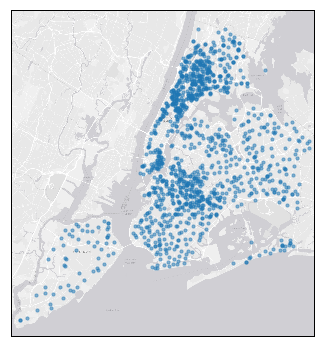

In [196]:
data = df.copy()

# plot little map
plt.figure(figsize=(8, 6))
map = plot_basemap()
lat = data['Latitude'].values
lon = data['Longitude'].values
x, y = map(lon, lat)
plt.scatter(x, y, alpha=0.5, s=10)

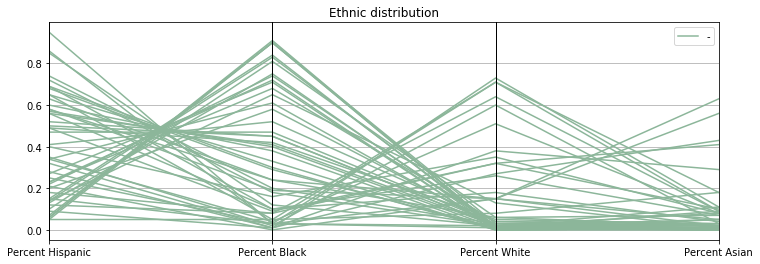

In [235]:
data = df.copy().sample(50, random_state=1)

# plot racial coordinates
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(12,4))
data = data[['Percent Hispanic', 'Percent Black', 'Percent White', 'Percent Asian']]
data['dummy'] = '-'
parallel_coordinates(data, 'dummy')
plt.title("Ethnic distribution");

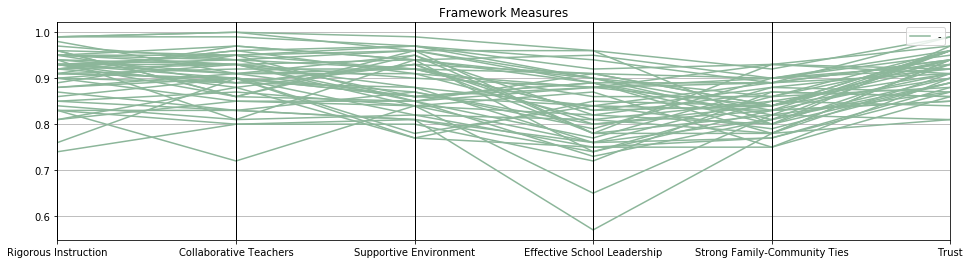

In [236]:
data = df.copy().sample(50, random_state=1)

# framework coordinates
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(16,4))
data = data[['Rigorous Instruction %', 'Collaborative Teachers %', 
             'Supportive Environment %', 'Effective School Leadership %', 
             'Strong Family-Community Ties %', 'Trust %']]
data.columns = [c[:-2] for c in data.columns]
data['dummy'] = '-'
parallel_coordinates(data, 'dummy')
plt.title("Framework Measures");

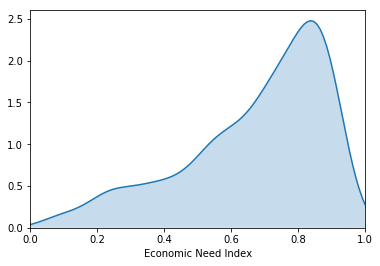

In [292]:
data = df.copy()

# ENI distplot (remove NA)
import seaborn as sns

plt.figure(figsize=(6,4))
data = data[data['Economic Need Index'].notnull()]
sns.distplot(data['Economic Need Index'], hist=False, kde_kws={"shade": True})
plt.xlim(0, 1);

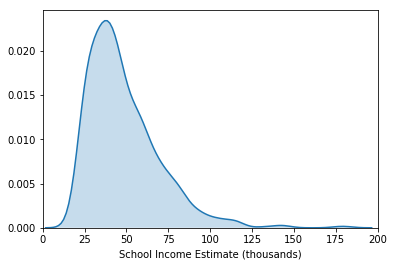

In [293]:
data = df.copy()

# school income (remove NA)
import seaborn as sns

plt.figure(figsize=(6,4))
data = data[data['School Income Estimate'].notnull()]
data['School Income Estimate (thousands)'] = data['School Income Estimate'] / 1000
sns.distplot(data['School Income Estimate (thousands)'], hist=False, kde_kws={"shade": True})
plt.xlim(0, 200);

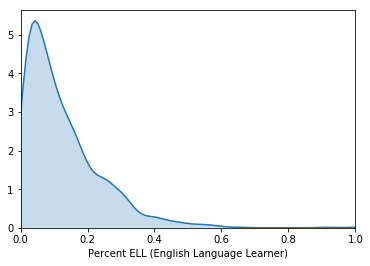

In [294]:
data = df.copy()

# Percent ELL distplot
import seaborn as sns

plt.figure(figsize=(6,4))
sns.distplot(data['Percent ELL'], hist=False, kde_kws={"shade": True})
plt.xlim(0, 1);
plt.xlabel('Percent ELL (English Language Learner)');

<Figure size 432x288 with 0 Axes>

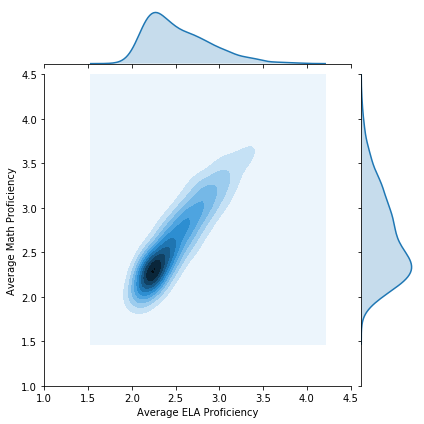

In [296]:
data = df.copy()

# ELA/MATH jointplot
import seaborn as sns

plt.figure(figsize=(6,4))
sns.jointplot('Average ELA Proficiency', 'Average Math Proficiency', data, 
              xlim=(1.0 ,4.5), ylim=(1.0, 4.5), stat_func=None, kind='kde');

<Figure size 432x288 with 0 Axes>

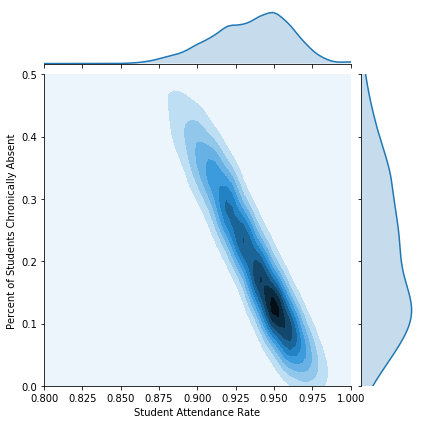

In [308]:
data = df.copy()

# attendance jointplot (seek deeper information later)
import seaborn as sns

plt.figure(figsize=(6,4))
sns.jointplot('Student Attendance Rate', 'Percent of Students Chronically Absent', data,
              xlim=(0.8, 1.0), ylim=(0.0, 0.5),
              stat_func=None, kind='kde');

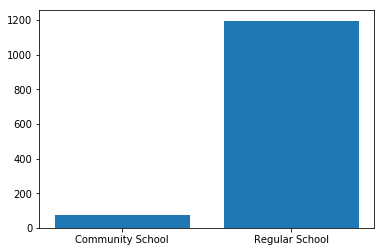

In [339]:
data = df.copy()

# Community school barplot (NA)
cnt = data.groupby('Community School?').size()

xs = ['Community School', 'Regular School']
ys = [cnt[1], cnt[0]]
plt.bar(xs, ys);

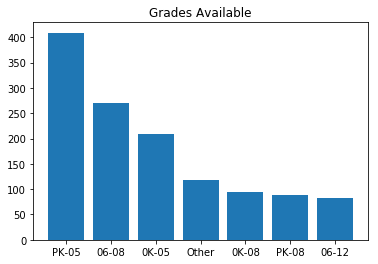

In [379]:
data = df.copy()

# Available grades barplot
grades = data.apply(lambda x: x['Grade Low'] + '-' + x['Grade High'], axis=1)
grades_cnt = grades.value_counts().to_dict()
grades_simple = grades.apply(lambda x: x if grades_cnt[x] > 50 else 'Other')

ys = grades_simple.value_counts()
xs = ys.index
plt.bar(xs, ys)
plt.title('Grades Available');

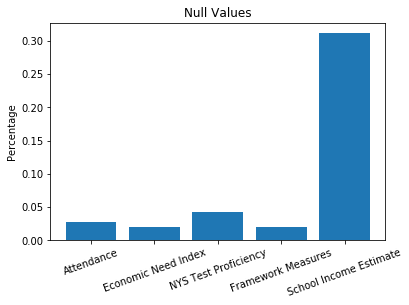

In [396]:
data = df.copy()

# NA Analysis

eni = data['Economic Need Index'].isnull().mean()
sie = data['School Income Estimate'].isnull().mean()
attendance = data[['Student Attendance Rate', 
                   'Percent of Students Chronically Absent']].isnull().any(axis=1).mean()
proficiency = data[['Average ELA Proficiency',
                    'Average Math Proficiency']].isnull().any(axis=1).mean()
framework = data[['Rigorous Instruction %', 'Collaborative Teachers %', 
                  'Supportive Environment %', 'Effective School Leadership %', 
                  'Strong Family-Community Ties %', 'Trust %']].isnull().any(axis=1).mean()

xs = ['Attendance', 'Economic Need Index', 'NYS Test Proficiency', 
      'Framework Measures', 'School Income Estimate']
ys = [attendance, eni, proficiency,
      framework, sie]

plt.title('Null Values')
plt.bar(xs, ys)
plt.xticks(rotation=20)
plt.ylabel('Percentage');

In [ ]:
data = df.copy()

# plot little map
# racial parallel coordinates
# framework parallel coordinates
# ENI distplot
# school income distplot
# ELL distplot
# ELA/MATH jointplot
# attendance rate + % chronically absent 2d plot
# Community school barplot
# grades information (?)
# NA information

# 4s bar (?) -- grades

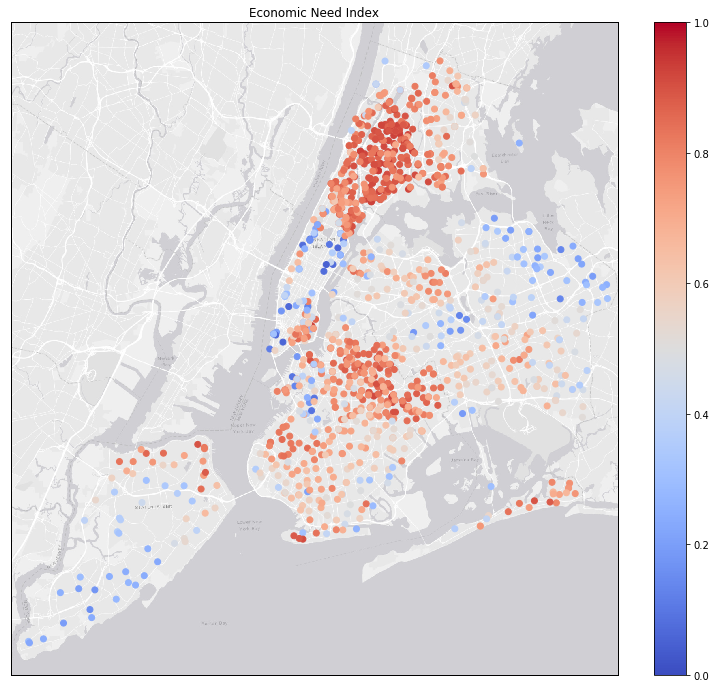

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

def plot_basemap(ax=None):
    m = Basemap(projection='merc',
                llcrnrlat=40.486,
                llcrnrlon=-74.261,
                urcrnrlat=40.925,
                urcrnrlon=-73.691,
                resolution='c',
                epsg='3623')
    m.arcgisimage(
        server='http://server.arcgisonline.com/ArcGIS', 
        service='Canvas/World_Light_Gray_Base', 
        xpixels=1500,
        ypixels=None, 
        dpi=96,
        verbose=False,
        ax=ax)
    m.drawmapboundary(ax=ax)
    return m
        
def plot_cluster_map(cluster, data, **kwargs):
    plt.figure(figsize=(16,12))
    m = plot_basemap()
    for c, d in data.groupby(cluster):        
        lat = d['Latitude'].values
        lon = d['Longitude'].values
        x, y = m(lon, lat)
        plt.scatter(x, y, label=c, **kwargs)
    plt.title(cluster.name)
    plt.legend()
    
def plot_continuous_map(features, data, **kwargs):
    fig, ax = plt.subplots(figsize=(16,12))
    m = plot_basemap()    
    
    lat = data['Latitude'].values
    lon = data['Longitude'].values
    x, y = m(lon, lat)    
    plt.scatter(x, y, c=features, **kwargs)
    
    plt.title(features.name)
    plt.colorbar(fraction=0.046, pad=0.04)  # magic padding https://stackoverflow.com/a/26720422/
    
def plot_statistics(data):
    raise NotImplementedError
    
def plot_cluster_statistics(cluster, data):
    raise NotImplementedError
    

plot_continuous_map(df['Economic Need Index'], df, cmap='coolwarm', vmin=0, vmax=1)

---

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/2016 School Explorer.csv')

# set index
df = df.set_index('Location Code')
df.index.name = 'DBN'

# select columns
columns = [
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent White'
]
df = df[columns]

# parse percentage values
def parse_pct(x):
    return float(x[:-1]) / 100.0
df = df.applymap(parse_pct)

df.head()

,Percent Asian,Percent Black,Percent Hispanic,Percent White
DBN,,,,
01M015,0.05,0.32,0.60,0.01
01M019,0.10,0.20,0.63,0.06
01M020,0.35,0.08,0.49,0.04
01M034,0.05,0.29,0.63,0.04
01M063,0.04,0.20,0.65,0.10


## Grouping the schools

In [134]:
import numpy as np
from scipy.stats import entropy
from sklearn.metrics.pairwise import pairwise_distances

def distance(x, y):
    return entropy(np.maximum(x, 0.005), np.maximum(y, 0.005))

def distance_kernel(data):
    return pairwise_distances(data, metric=distance, n_jobs=-1)

kernel = distance_kernel(df)

In [160]:
from sklearn.metrics import calinski_harabaz_score, silhouette_score

# these metrics are indicative of a good fit... the higher the better
for i in range(2, 21):
    model = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='average')    
    labels = model.fit_predict(kernel)
    score1 = calinski_harabaz_score(df, labels)
    score2 = silhouette_score(df, labels)
    print(i, score1, score2)

2 575.8507631552575 0.33823516438713586
3 1457.0820296309587 0.5199629206625567
4 1064.7087699295614 0.36858395640060143
5 816.3636281232389 0.32045006536078563
6 1118.0604952531307 0.38033340545314304
7 1126.2267094270308 0.42014300547931754
8 980.2418797312665 0.4143529214669579
9 885.8896316595456 0.35474449408346836
10 797.1916513332768 0.3359601043965502
11 745.0120883517334 0.3066517567831011
12 681.883748381853 0.2958975084447057
13 630.5761881307105 0.2711665771786537
14 588.0074889289444 0.26762258159479657
15 549.8865566701461 0.24929554836122028
16 534.7222741341794 0.2309951878065498
17 501.75086153224646 0.22657160702246246
18 491.9604398648129 0.2206618414370624
19 465.3437809473548 0.21751259461122657
20 447.6827772532738 0.21275173269469053


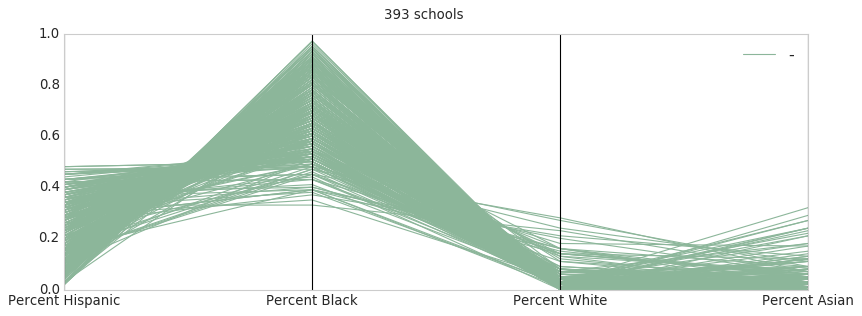

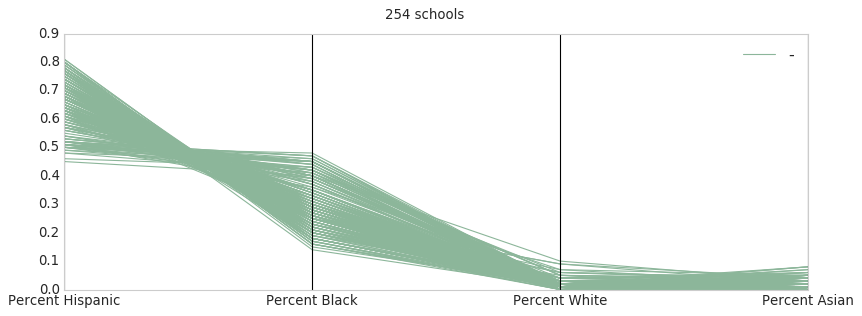

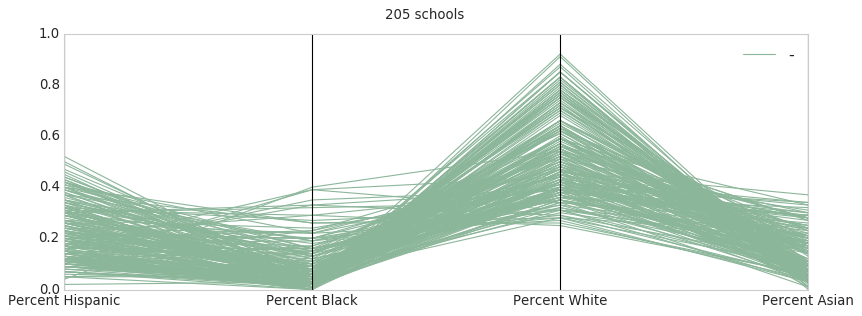

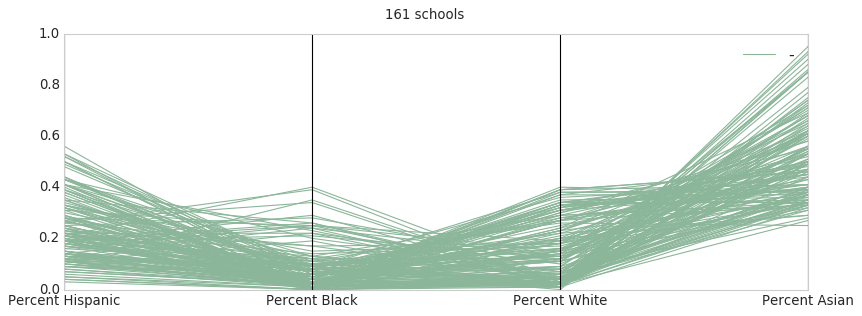

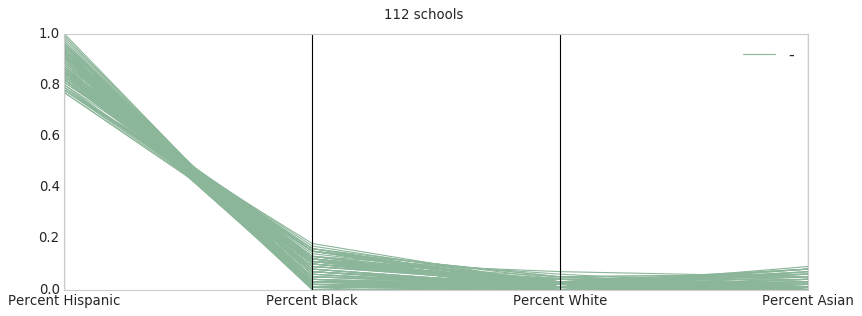

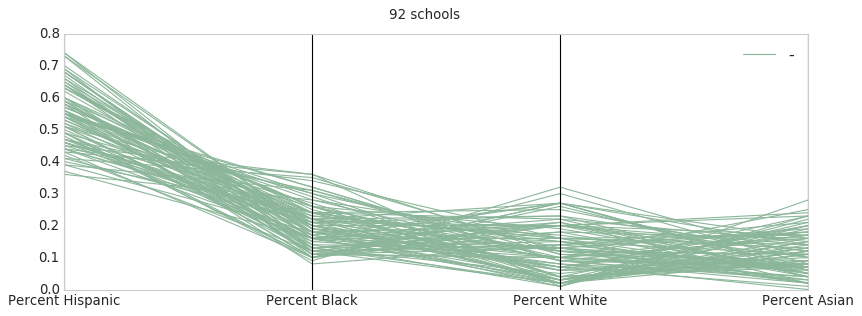

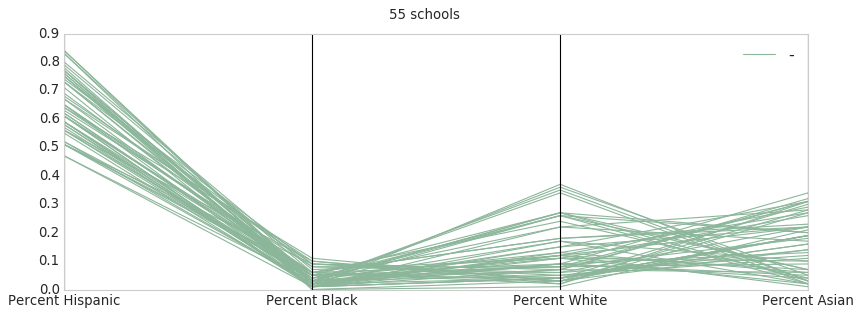

In [170]:
model = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='average')
labels = model.fit_predict(kernel)

for label in sorted(set(labels), key=lambda x: -df[labels==x].shape[0]):
    d = df[labels == label].copy()
    d = d[['Percent Hispanic', 'Percent Black', 'Percent White', 'Percent Asian']]
    d['dummy'] = '-'
    
    plt.figure(figsize=(12,4))
    plt.suptitle("{} schools".format(d.shape[0]))
    parallel_coordinates(d, 'dummy');